In [1]:
import pandas as pd
final_df=pd.read_csv('../Dataset/final_df.csv')

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load geojson
gdf = gpd.read_file("../Dataset/GeoJSON/india_pincode.geojson")

TOP 5 STATES WITH LOWEST ADULT ENROLMENT

In [3]:

enr_cols = [
    "enr_age_0_5",
    "enr_age_5_17",
    "enr_age_18_greater"
]

final_df[enr_cols] = (
    final_df[enr_cols]
    .apply(pd.to_numeric, errors="coerce")
    .fillna(0)
)

state_enrol = (
    final_df
    .groupby("state", as_index=False)[enr_cols]
    .sum()
)


In [4]:
top_5_low_enr_18 = (
    state_enrol
    .sort_values("enr_age_18_greater", ascending=True)
    .head(5)
)

top_5_low_enr_18


,state,enr_age_0_5,enr_age_5_17,enr_age_18_greater
0,Andaman And Nicobar Islands,436.0,30.0,0.0
18,Lakshadweep,197.0,10.0,1.0
17,Ladakh,495.0,137.0,21.0
5,Chandigarh,2598.0,221.0,41.0
26,Puducherry,1809.0,127.0,49.0


In [5]:
india_states = gpd.read_file("../Dataset/GeoJSON/india_state_geo.json")


In [6]:
india_states["state_norm"] = (
    india_states["NAME_1"]
    .str.lower()
    .str.replace("&", "and")
    .str.replace(" islands", "", regex=False)
    .str.strip()
)

top_5_low_enr_18["state_norm"] = (
    top_5_low_enr_18["state"]
    .str.lower()
    .str.replace("&", "and")
    .str.replace(" islands", "", regex=False)
    .str.strip()
)


In [7]:
top_states_geo = india_states.merge(
    top_5_low_enr_18,
    on="state_norm",
    how="inner"
)


<Axes: >

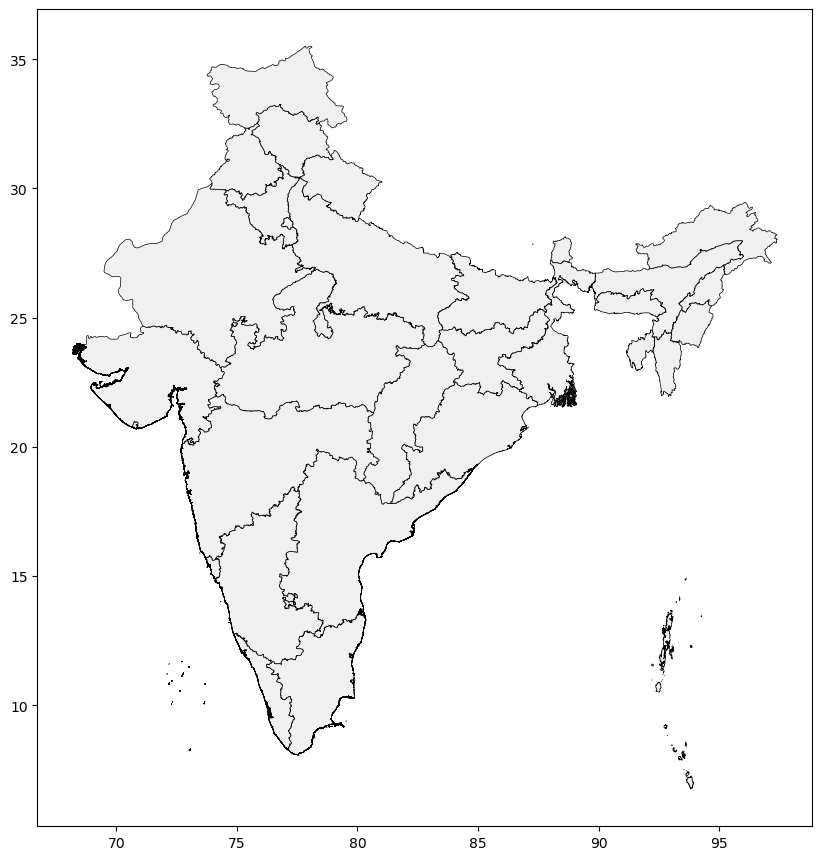

In [ ]:
fig, ax = plt.subplots(figsize=(10, 12))

# Plot all states
india_states.plot(
    ax=ax,
    color="#f0f0f0",
    edgecolor="black",
    linewidth=0.5
)

# Highlight bottom 5 states
top_states_geo.plot(
    ax=ax,
    color="#d73027",   # strong red
    edgecolor="black",
    linewidth=1
)

# Add labels
for idx, row in top_states_geo.iterrows():
    ax.annotate(
        text=row["state"],
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
        ha="center",
        fontsize=9,
        fontweight="bold",
        color="black"
    )

ax.set_title(
    "Bottom 5 States by Aadhaar Enrolment (Age ≥ 18)",
    fontsize=16
)

ax.axis("off")
plt.tight_layout()
plt.show()


Low Aadhaar enrolment among adults in these regions increases the risk of exclusion from welfare schemes, especially DBT-linked services.

This directly impacts:

PDS

Health insurance

Pension schemes

Disaster relief



---------NEWS---------
Official Review Notes: Low Aadhaar Registration in Ladakh

The administration of Ladakh has publicly acknowledged low numbers of Aadhaar registrations and technical implementation challenges during official review meetings:

In a review meeting convened by the Deputy Commissioner of Leh, officials discussed low registration numbers for Aadhaar along with issues in online portals and implementation of related services.


SORCE------>https://www.reachladakh.com

ANALYSIS ON STATES WHOSE POPLATION ARE MORE BUT ENROLMENT IS LESS AS COMPARED TO OTHERS

In [13]:
population_df=pd.read_csv('../Dataset/state_population.csv')        
#This file contains population of states as per 2011 census

In [14]:
population_df.head()

,state,population
0,Uttar Pradesh,199812341
1,Maharashtra,112374333
2,Bihar,104099452
3,West Bengal,91276115
4,Madhya Pradesh,72626809


In [15]:
state_enrol_18 = (
    final_df
    .groupby("state", as_index=False)
    .agg(
        enr_18_plus=("enr_age_18_greater", "sum"),
        enr_5_17=('enr_age_5_17', 'sum'),
        enr_0_5=('enr_age_0_5', 'sum')
    )
)


state_pop_enrol = (
    state_enrol_18
    .merge(population_df, on="state", how="inner")
)



In [16]:
state_pop_enrol["enr_18_per_1000"] = (
    state_pop_enrol["enr_18_plus"] / state_pop_enrol["population"]
) * 1000

state_pop_enrol["enr_5_17_per_1000"] = (
    state_pop_enrol["enr_5_17"] / state_pop_enrol["population"]
) * 1000

state_pop_enrol["enr_0_5_per_1000"] = (
    state_pop_enrol["enr_0_5"] / state_pop_enrol["population"]
) * 1000


In [17]:
high_pop_threshold = state_pop_enrol["population"].quantile(0.50)


In [19]:
low_18_thr = state_pop_enrol["enr_18_per_1000"].quantile(0.25)
low_5_17_thr = state_pop_enrol["enr_5_17_per_1000"].quantile(0.25)
low_0_5_thr = state_pop_enrol["enr_0_5_per_1000"].quantile(0.25)


state_pop_enrol["risk_18_plus"] = (
    (state_pop_enrol["population"] >= high_pop_threshold) &
    (state_pop_enrol["enr_18_per_1000"] <= low_18_thr)
)

state_pop_enrol["risk_5_17"] = (
    (state_pop_enrol["population"] >= high_pop_threshold) &
    (state_pop_enrol["enr_5_17_per_1000"] <= low_5_17_thr)
)

state_pop_enrol["risk_0_5"] = (
    (state_pop_enrol["population"] >= high_pop_threshold) &
    (state_pop_enrol["enr_0_5_per_1000"] <= low_0_5_thr)
)


In [20]:
state_pop_enrol["risk_score"] = (
    state_pop_enrol["risk_18_plus"].astype(int) +
    state_pop_enrol["risk_5_17"].astype(int) +
    state_pop_enrol["risk_0_5"].astype(int)
)


In [21]:
final_risk_table = (
    state_pop_enrol
    .sort_values("risk_score", ascending=False)
    [
        [
            "state",
            "population",
            "enr_18_per_1000",
            "enr_5_17_per_1000",
            "enr_0_5_per_1000",
            "risk_score"
        ]
    ]
)

final_risk_table


,state,population,enr_18_per_1000,enr_5_17_per_1000,enr_0_5_per_1000,risk_score
0,Andhra Pradesh,84580777,0.013478,0.098793,1.024855,3
21,Odisha,41974218,0.011174,0.419710,1.857283,2
13,Kerala,33406061,0.085703,0.568220,1.639822,1
12,Karnataka,61095297,0.100597,0.342645,1.916039,1
26,Tamil Nadu,72147030,0.016217,0.442846,2.227036,1
3,Bihar,104099452,0.102681,3.089699,2.500042,0
5,Chhattisgarh,25545198,0.075200,0.705377,3.089818,0
4,Chandigarh,1055450,0.038846,0.209389,2.461509,0
6,Delhi,16787941,0.184359,1.333457,4.153279,0
7,Goa,1458545,0.113126,0.184430,1.365745,0


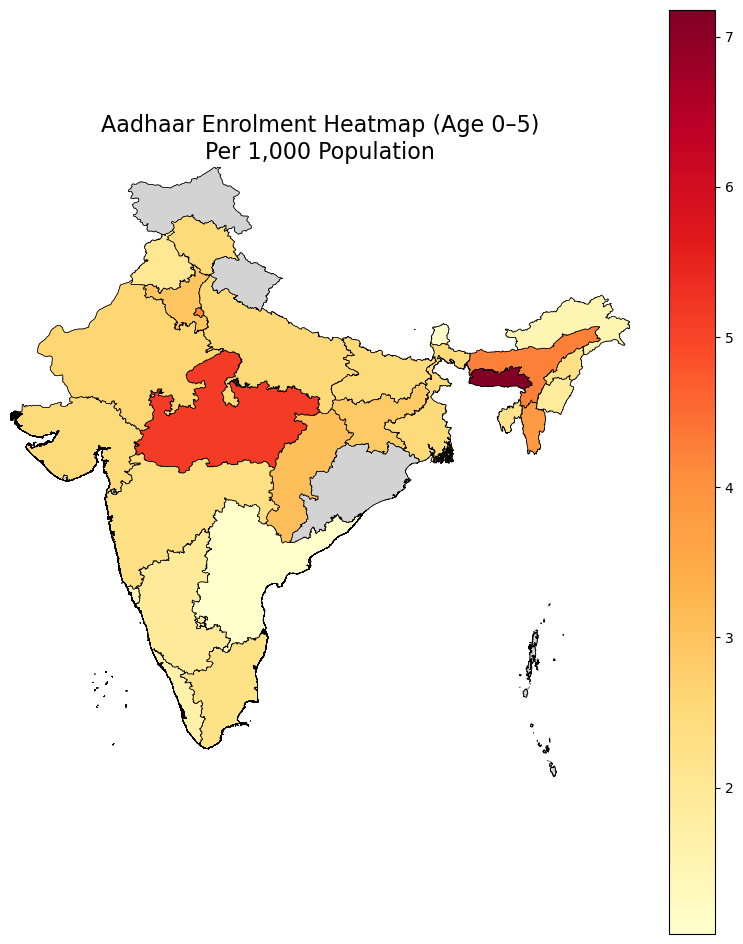

In [41]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# -------------------------------
# 1. LOAD INDIA STATE GEOJSON
# -------------------------------
india_states = gpd.read_file("../Dataset/GeoJSON/india_state_geo.json")

# Normalize state names (GeoJSON)
india_states["state_norm"] = (
    india_states["NAME_1"]
    .str.lower()
    .str.replace("&", "and")
    .str.replace(" islands", "", regex=False)
    .str.strip()
)

# -------------------------------
# 2. NORMALIZE STATE NAMES (DATA)
# -------------------------------
state_pop_enrol["state_norm"] = (
    state_pop_enrol["state"]
    .str.lower()
    .str.replace("&", "and")
    .str.replace(" islands", "", regex=False)
    .str.strip()
)

# -------------------------------
# 3. MERGE GEO + DATA
# -------------------------------
india_map_df = india_states.merge(
    state_pop_enrol,
    on="state_norm",
    how="left"
)

# -------------------------------
# 4. GET INDIA BOUNDS (CRITICAL)
# -------------------------------
xmin, ymin, xmax, ymax = india_states.total_bounds

# -------------------------------
# 5. PLOT HEATMAP (AGE 0–5)
# -------------------------------
fig, ax = plt.subplots(figsize=(10, 12))

# Base map (same as your working map)
india_states.plot(
    ax=ax,
    color="#f0f0f0",
    edgecolor="black",
    linewidth=0.5
)

# Heatmap overlay
india_map_df.plot(
    column="enr_0_5_per_1000",
    cmap="YlOrRd",
    linewidth=0.5,
    edgecolor="black",
    legend=True,
    missing_kwds={
        "color": "lightgrey",
        "label": "No data"
    },
    ax=ax
)

# 🔑 ABSOLUTE FIX (DO NOT REMOVE)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_aspect("equal")

# Title
ax.set_title(
    "Aadhaar Enrolment Heatmap (Age 0–5)\nPer 1,000 Population",
    fontsize=16
)

ax.axis("off")
plt.show()


Evidence

Most states show higher enrolment intensity for 0–5

Heatmaps for 0–5 are noticeably darker than 18+

Interpretation

Enrolment likely linked to:

Birth registration

Anganwadi services

Early immunization programmes

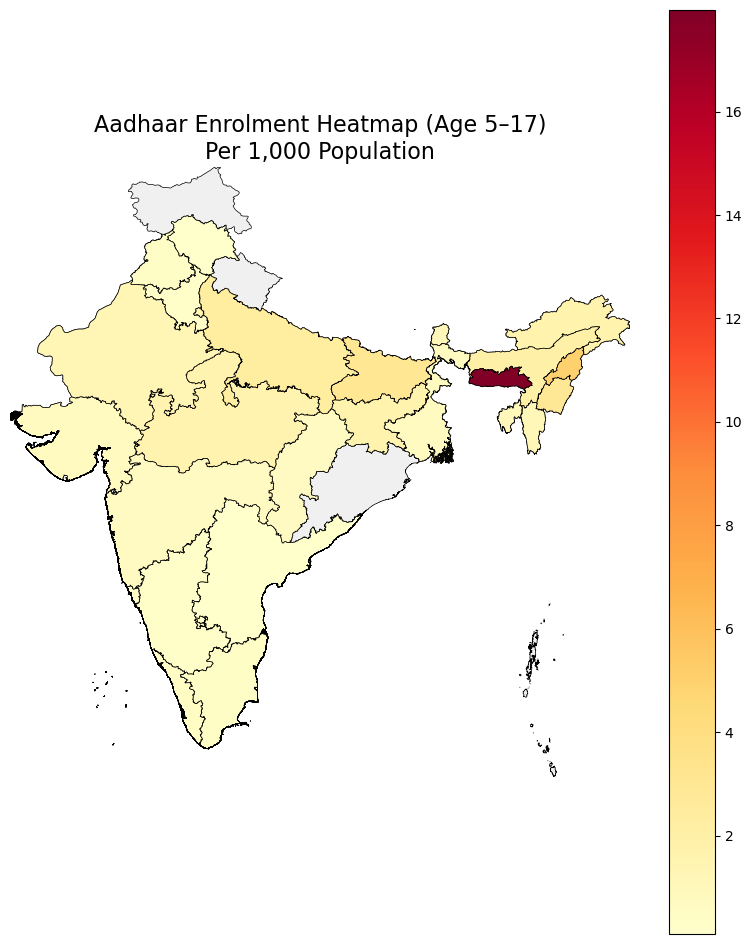

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# -------------------------------
# 1. LOAD INDIA STATE GEOJSON
# -------------------------------
india_states = gpd.read_file("../Dataset/GeoJSON/india_state_geo.json")

# Normalize state names (GeoJSON)
india_states["state_norm"] = (
    india_states["NAME_1"]
    .str.lower()
    .str.replace("&", "and")
    .str.replace(" islands", "", regex=False)
    .str.strip()
)

# -------------------------------
# 2. NORMALIZE STATE NAMES (DATA)
# -------------------------------
state_pop_enrol["state_norm"] = (
    state_pop_enrol["state"]
    .str.lower()
    .str.replace("&", "and")
    .str.replace(" islands", "", regex=False)
    .str.strip()
)

# -------------------------------
# 3. MERGE GEO + DATA
# -------------------------------
india_map_df = india_states.merge(
    state_pop_enrol,
    on="state_norm",
    how="left"
)

# -------------------------------
# 4. GET INDIA BOUNDS (CRITICAL)
# -------------------------------
xmin, ymin, xmax, ymax = india_states.total_bounds

# -------------------------------
# 5. PLOT HEATMAP (AGE 5-17)
# -------------------------------
fig, ax = plt.subplots(figsize=(10, 12))

# Base map (same as your working map)
india_states.plot(
    ax=ax,
    color="#f0f0f0",
    edgecolor="black",
    linewidth=0.5
)

# Heatmap overlay
india_map_df.plot(
    column="enr_5_17_per_1000",
    cmap="YlOrRd",
    linewidth=0.5,
    edgecolor="black",
    legend=True,
    missing_kwds={
        "color": "lightgrey",
        "label": "No data"
    },
    ax=ax
)

# 🔑 ABSOLUTE FIX (DO NOT REMOVE)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_aspect("equal")

# Title
ax.set_title(
    "Aadhaar Enrolment Heatmap (Age 5–17)\nPer 1,000 Population",
    fontsize=16
)

ax.axis("off")
plt.show()


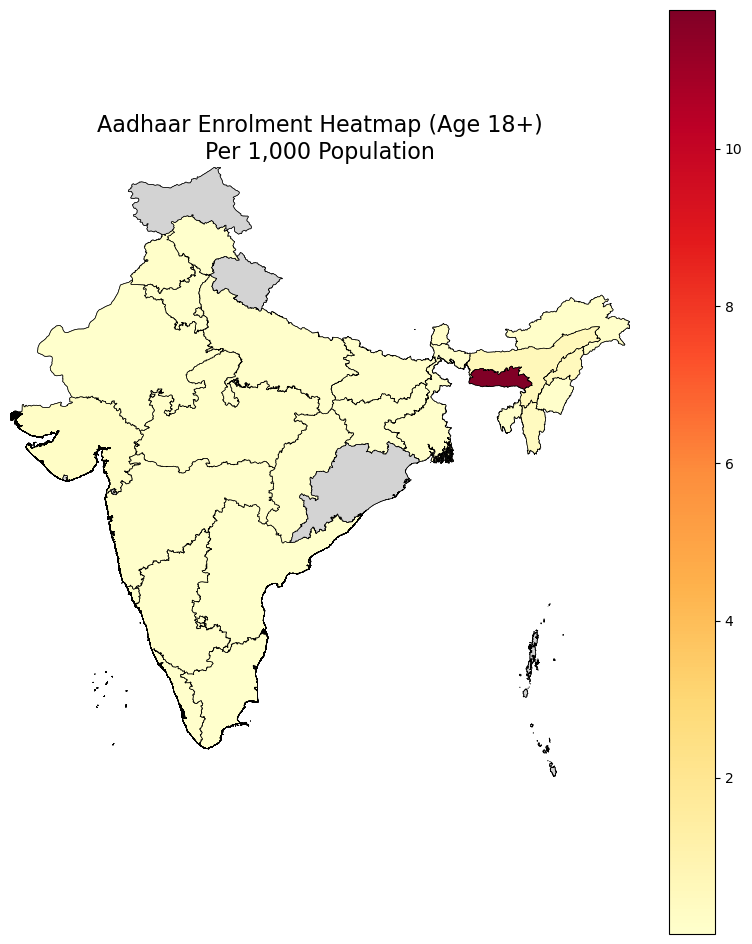

In [42]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# -------------------------------
# 1. LOAD INDIA STATE GEOJSON
# -------------------------------
india_states = gpd.read_file("../Dataset/GeoJSON/india_state_geo.json")

# Normalize state names (GeoJSON)
india_states["state_norm"] = (
    india_states["NAME_1"]
    .str.lower()
    .str.replace("&", "and")
    .str.replace(" islands", "", regex=False)
    .str.strip()
)

# -------------------------------
# 2. NORMALIZE STATE NAMES (DATA)
# -------------------------------
state_pop_enrol["state_norm"] = (
    state_pop_enrol["state"]
    .str.lower()
    .str.replace("&", "and")
    .str.replace(" islands", "", regex=False)
    .str.strip()
)

# -------------------------------
# 3. MERGE GEO + DATA
# -------------------------------
india_map_df = india_states.merge(
    state_pop_enrol,
    on="state_norm",
    how="left"
)

# -------------------------------
# 4. GET INDIA BOUNDS (CRITICAL)
# -------------------------------
xmin, ymin, xmax, ymax = india_states.total_bounds

# -------------------------------
# 5. PLOT HEATMAP (AGE 0–5)
# -------------------------------
fig, ax = plt.subplots(figsize=(10, 12))

# Base map (same as your working map)
india_states.plot(
    ax=ax,
    color="#f0f0f0",
    edgecolor="black",
    linewidth=0.5
)

# Heatmap overlay
india_map_df.plot(
    column="enr_18_per_1000",
    cmap="YlOrRd",
    linewidth=0.5,
    edgecolor="black",
    legend=True,
    missing_kwds={
        "color": "lightgrey",
        "label": "No data"
    },
    ax=ax
)

# 🔑 ABSOLUTE FIX (DO NOT REMOVE)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_aspect("equal")

# Title
ax.set_title(
    "Aadhaar Enrolment Heatmap (Age 18+)\nPer 1,000 Population",
    fontsize=16
)

ax.axis("off")
plt.show()


Evidence from data

Most states show very low enrolment intensity for age 18+
Even high-population states (e.g., Andhra Pradesh, Tamil Nadu, Odisha) show low adult enrolment per 1,000 population
Why this matters to government

Aadhaar is mandatory for DBT-linked schemes, including:

PDS

PM-JAY (health insurance)

Pension schemes

Subsidy transfers

Low adult enrolment directly increases exclusion risk

Policy insight

The transition from minor to adult Aadhaar status represents a critical policy gap.

North-Eastern states show unusually high enrolment intensity — an outlier worth studying

Evidence
-----------
Meghalaya:

enr_18_per_1000 ≈ 11.76

Darkest shade on heatmap

Similar patterns in Nagaland, Assam




Interpretation
---------------
Possible causes:

Targeted enrolment drives

Smaller population base

Administrative focus





THERE WERE ENROLMENT DRIVES IN MEGHALAYA IN THE YEAR 2025, AS EARLIER THE ENROLMENT WAS VERY POOR
SOURCE----->  IndiaToday NE - Despite commendable progress in biometric... | Facebook https://share.google/MqjnPB0hiO4bb5p77

Early-life Aadhaar integration is institutionally successful
------------------------------------------------------------
What the data shows---------------->

Enrolment intensity for age 0–5 is consistently higher than adult enrolment across most states.

Heatmaps show darker shades for 0–5 compared to 18+.

Why this is crucial

Confirms that institution-linked enrolment (birth registration, hospitals, Anganwadi, immunisation) is working.

Indicates that Aadhaar is becoming embedded early in the citizen lifecycle.

Policy-positive takeaway

The Aadhaar ecosystem is strongest where enrolment is institution-driven rather than voluntary.



---------------------
(POSITIVE INSIGHTS)
---------------------

School-age (5–17) enrolment shows scale-up capability
-------------------------------------------------------
What the data shows------------------->

Several large states (UP, Bihar, MP, WB) show moderate to strong enrolment intensity for 5–17.

Enrolment rebounds after the 0–5 stage in many regions.

Why this matters

Demonstrates the success of school-linked identity enforcement (scholarships, exams, mid-day meals).

Shows that Aadhaar systems can scale rapidly when incentives exist.

Policy-positive takeaway

When Aadhaar enrolment is linked to service access, uptake improves significantly.


---------------------
(NEGATIVE INSIGHTS)
---------------------


Adult Aadhaar enrolment is structurally weak nationwide
-------------------------------------------------------------
What the data shows

Adult (18+) enrolment intensity is the lowest across all age groups

Most states fall into lightest shade for 18+ heatmaps.

Even economically advanced states show low adult enrolment per 1,000 population.

Why this is critical

Adults are the primary beneficiaries of:

PDS

PM-JAY

Pensions

Subsidies

Low adult enrolment → direct welfare exclusion risk

Policy-risk takeaway

India’s Aadhaar system is weakest at the exact point where welfare dependence is highest.



 High-population states show silent but massive exclusion risk
-----------------------------------------------------------------
What the data shows

States like Andhra Pradesh, Tamil Nadu, Odisha have:

Large populations

Very low adult enrolment intensity

Andhra Pradesh shows risk across all age groups (risk_score = 3).

Why this is dangerous

A small percentage gap here = millions excluded

These risks are invisible in absolute enrolment numbers

Policy-risk takeaway

Population-normalized analysis reveals enrolment risks that raw counts completely hide.



No structured transition from minor to adult Aadhaar status
---------------------------------------------------------------
What the data shows

Strong enrolment at 0–5

Moderate at 5–17

Sharp collapse at 18+

What this implies

Aadhaar update at adulthood is:

Not enforced

Not incentivized

Not institutionally triggered

Policy-risk takeaway

The transition to adulthood is a major structural break in Aadhaar coverage.



Multi-age enrolment gaps signal deep governance issues
-----------------------------------------------------------
What the data shows

Very few states show gaps across all age groups

Where present (e.g., Andhra Pradesh), the risk is severe

Why this is alarming

Indicates:

Poor coordination

Weak state-level implementation

Potential governance bottlenecks

Policy-risk takeaway

Multi-age enrolment gaps should trigger immediate administrative review.